In [1]:

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, ttest_ind
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
#Đọc dữ liệu từ file cvs và hiển thị nội dung để kiểm tra 
df_date = pd.read_csv("dataset_weather.csv")
print(df_date.head()) #hiển thị 5 dòng đầu tiên của dữ liệu

         date  precipitation  temp_max  temp_min  wind weather
0  2004-01-01           11.2        32        15   5.4  Cloudy
1  2004-01-02           28.5        34        24   9.2   Rainy
2  2004-01-03           22.0        33        24   1.6  Cloudy
3  2004-01-04           18.0        27        21   1.2  Cloudy
4  2004-01-05            4.7        30        23   8.6  Cloudy


In [3]:
df_date.info() #Kiểm tra thông tin dữ liệu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9154 entries, 0 to 9153
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           9154 non-null   object 
 1   precipitation  9154 non-null   float64
 2   temp_max       9154 non-null   int64  
 3   temp_min       9154 non-null   int64  
 4   wind           9154 non-null   float64
 5   weather        9154 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 429.2+ KB


In [4]:
df_date.date = pd.to_datetime(df_date.date).dt.month #chuyển đổi định dạng ngày tháng về dạng số tháng 
df_date.date #Kiểm tra lại dữ liệu sau khi chuyển đổi 

0        1
1        1
2        1
3        1
4        1
        ..
9149    12
9150    12
9151    12
9152    12
9153    12
Name: date, Length: 9154, dtype: int32

In [5]:
df_date = df_date.rename(columns = {'date':'month'}) #Đổi tên cột date thành month để dễ hiểu hơn 
df_date.head() #Kiểm tra lại dữ liệu sau khi đổi tên

,month,precipitation,temp_max,temp_min,wind,weather
0,1,11.2,32,15,5.4,Cloudy
1,1,28.5,34,24,9.2,Rainy
2,1,22.0,33,24,1.6,Cloudy
3,1,18.0,27,21,1.2,Cloudy
4,1,4.7,30,23,8.6,Cloudy


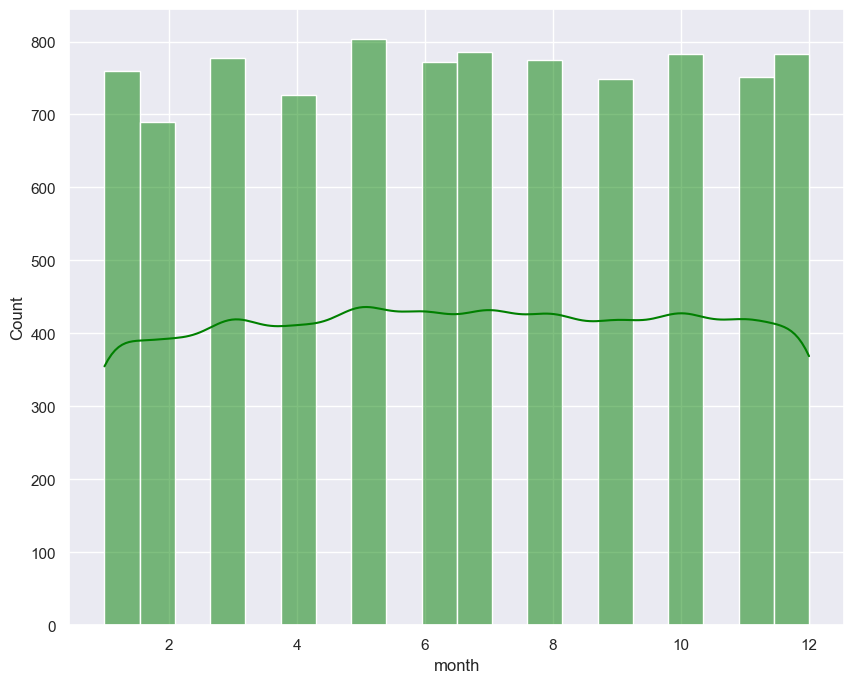

In [6]:
#Vẽ biểu đồ theer hiện số lựng dữ liệu theo từng tháng 

sns.set(style="darkgrid") #Thiết lập giao diện biểu đồ là darkgrid
fig, axs = plt.subplots(figsize=(10, 8)) #Tạo một biểu đồ với kích thước 10x8 inch
#Vẽ biểu đồ histogram với dữ liệu tháng và hiển thị đường phân phối chuẩn (kde)
plot = sns.histplot(data=df_date, x="month", kde=True, color='green')


In [7]:

lc_date = LabelEncoder() #Khởi tạo LabelEncoder để mã hóa nhãn
#Mã hóa các nhãn trong cột weather thành các số nguyên
df_date["weather"] = lc_date.fit_transform(df_date["weather"])
df_date.head()

,month,precipitation,temp_max,temp_min,wind,weather
0,1,11.2,32,15,5.4,0
1,1,28.5,34,24,9.2,1
2,1,22.0,33,24,1.6,0
3,1,18.0,27,21,1.2,0
4,1,4.7,30,23,8.6,0


In [8]:
#Loại bỏ các outlier trong dữ liệu bằng phương pháp IQR

Q1_date = df_date.quantile(0.25) #Tính toán giá trị Q1 của dữ liệu
Q3_date = df_date.quantile(0.75) #Tính toán giá trị Q3 của dữ liệu
IQR_date = Q3_date - Q1_date     #Tính toán khoảng IQR
df, _ = df_date.align((Q1_date - 1.5 * IQR_date) | (df_date > (Q3_date + 1.5 * IQR_date)), axis=1, copy=False)
df_date = df_date.dropna()

In [9]:
#Chuẩn hóa dữ liệu
df_date.precipitation=np.sqrt(df_date.precipitation)
df_date.wind=np.sqrt(df_date.wind)

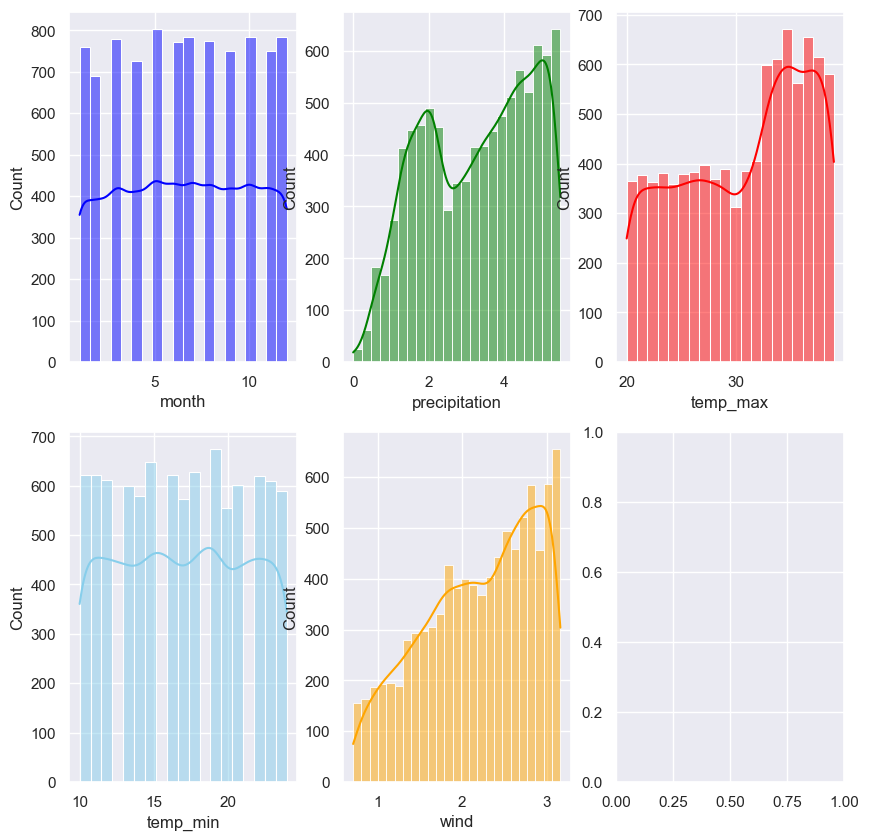

In [10]:
#Trực quan hóa phân phối của các biến trong DataFrame df_date thông qua biểu đồ histogram

sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

plots = ["month", "precipitation", "temp_max", "temp_min", "wind"]

for i, plot in enumerate(plots):
    sns.histplot(data=df_date, x=plot, kde=True, ax=axs[i//3, i%3], color=["blue", "green", "red", "skyblue", "orange"][i])

In [11]:
# Tách dữ liệu thành biến đặc trưng và biến mục tiêu
# Extract the feature and target variables from the DataFrame
# Convert the features to integers and exclude the "weather" column
#
x_date = df_date.loc[:, df_date.columns != "weather"].astype(int).values

# Get the target variable as an array of values
y_date = df_date["weather"].values


In [12]:
#Tách dữ liệu thành tập huấn luyện và tập kiểm tra 

# Split the "x_date" and "y_date" datasets into training and testing sets
# with a test size of 0.1 (10% of the data) and a random state of 2 for reproducibility
x_train_date, x_test_date, y_train_date, y_test_date = train_test_split(x_date, y_date, test_size=0.1, random_state=2)


In [13]:
#Thực hiện huấn luyện mô hình Decision Tree Classifier với các tham số khác nhau 
from sklearn.tree import DecisionTreeClassifier

# Import the DecisionTreeClassifier model from sklearn.tree
# Create a list of values for the "max_depth" parameter to test
max_depth_range_date = list(range(1, 8))

# Loop through each value of "max_depth" in the list
for depth in max_depth_range_date:
  # Create a DecisionTreeClassifier model with the current value of "max_depth",
  # a fixed "max_leaf_nodes" value of 15, and a fixed "random_state" value of 0
  dec_date = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes=15, random_state=0)
  
  # Fit the model to the training data
  dec_date.fit(x_train_date, y_train_date)
  
  # Evaluate the model's accuracy on the test data
  dec_date_score = dec_date.score(x_test_date, y_test_date)
  
  # Print the accuracy score to the console, along with the current value of "max_depth"
  print("Decision Tree Accuracy (with month column) for max_depth=", depth, ": ", dec_date_score)


Decision Tree Accuracy (with month column) for max_depth= 1 :  0.6670305676855895
Decision Tree Accuracy (with month column) for max_depth= 2 :  0.7347161572052402
Decision Tree Accuracy (with month column) for max_depth= 3 :  0.881004366812227
Decision Tree Accuracy (with month column) for max_depth= 4 :  0.881004366812227
Decision Tree Accuracy (with month column) for max_depth= 5 :  0.8853711790393013
Decision Tree Accuracy (with month column) for max_depth= 6 :  0.8820960698689956
Decision Tree Accuracy (with month column) for max_depth= 7 :  0.8897379912663755


In [14]:
#Đo lường mô hình phân loại đúng hay sai bao nhiêu lần cho từng nhãn 
from sklearn.metrics import confusion_matrix

# Use the Decision Tree model to predict the target variable for the test set
y_pred_dec_date = dec_date.predict(x_test_date)

# Compute the confusion matrix for the Decision Tree model predictions
conf_matrix_dec_date = confusion_matrix(y_test_date, y_pred_dec_date)

# Print the confusion matrix to the console
print("Confusion Matrix (with month column)")
print(conf_matrix_dec_date)


Confusion Matrix (with month column)
[[445  55  28]
 [ 12 189   0]
 [  6   0 181]]


In [15]:
#Đánh giá chi tiết chất lượng mô hình phân loại 
print('Decision Tree (with month column)\n',classification_report(y_test_date,y_pred_dec_date, zero_division=0))

Decision Tree (with month column)
               precision    recall  f1-score   support

           0       0.96      0.84      0.90       528
           1       0.77      0.94      0.85       201
           2       0.87      0.97      0.91       187

    accuracy                           0.89       916
   macro avg       0.87      0.92      0.89       916
weighted avg       0.90      0.89      0.89       916



In [16]:
from sklearn.tree import DecisionTreeClassifier
# Chọn mô hình tốt nhất từ kết quả
best_model = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=15, random_state=0)
best_model.fit(x_train_date, y_train_date)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=15, random_state=0)

In [17]:
# Dự đoán 
input=[[3,0.4,33,10,6.7]]
ot = best_model.predict(input)
print("The weather is:")
if(ot==0):
    print("Cloudy")
elif(ot==1):
    print("rainy")
else:
    print("sunny")


The weather is:
sunny


In [18]:
from joblib import dump
# Lưu mô hình đã huấn luyện
dump(best_model, 'weather_model.joblib')

['weather_model.joblib']

In [19]:
# dataset được lấy từ trang wed :https://www.kaggle.com/datasets/ananthr1/weather-prediction
# Bài làm được tham khảo từ trang wed :https://github.com/Diwas524/Weather-Prediction-Using-Machine-Learning